In [1]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
dataset = datasets.MNIST('.', download=True)

In [3]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x10B0E60D0>, 5)

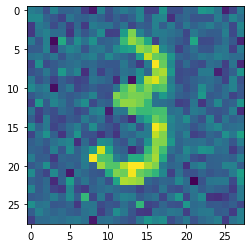

In [4]:
import matplotlib.pyplot as plt
noized = dataset.data[1234].float() / 255 + torch.normal(
    torch.zeros_like(dataset.data[1234].float()), 
    0.2 * torch.ones_like(dataset.data[1234].float()))
plt.imshow(noized.detach().numpy())
plt.show()

In [5]:
# hyperparams
in_chan = 1
hidden_ch = 50
out_ch = 1
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 5
batch_size = 256


In [6]:
class Encoder(nn.Module):
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.do = nn.Dropout(0.1)
        self.conv_mu = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.conv_sigma = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.do(self.activ(self.pool(self.conv1(x))))
        mu = self.conv_mu(x)
        sigma = torch.exp(self.conv_sigma(x))

        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.do = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(hidden_ch, in_chan, kernel_size=5, stride=1, padding=2)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.do(self.activ(self.upsample(self.conv1(x))))
        x = self.conv2(x)

        return x
    
def sampling(mu, sigma):
  norm = torch.normal(torch.zeros_like(sigma), torch.ones_like(sigma))
  return mu + sigma * norm

class ConvVarAutoEncoder(nn.Module):
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.encoder = Encoder(in_chan, hidden_ch, out_ch)
        self.decoder = Decoder(in_chan, hidden_ch, out_ch)

    def forward(self, x):
        mu, sigma = self.encoder(x)
        hidden = sampling(mu, sigma)
        x_ = self.decoder(hidden)

        return x_, mu, sigma


In [7]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [8]:
model_conv = ConvVarAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.MSELoss()

def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))

    return torch.distributions.kl_divergence(p, q).mean()

epoch: 0, step: 0, loss: 0.3547305762767792
epoch: 0, step: 200, loss: 0.021804414689540863


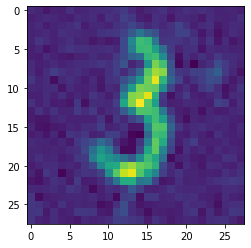

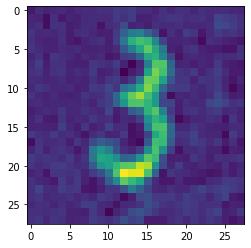

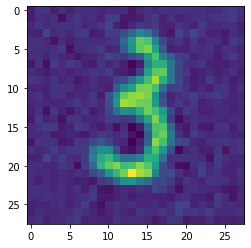

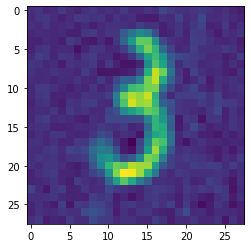

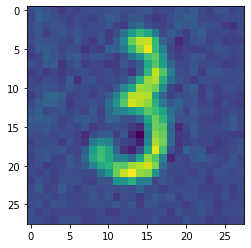

epoch: 1, step: 0, loss: 0.02101132646203041
epoch: 1, step: 200, loss: 0.01824711263179779


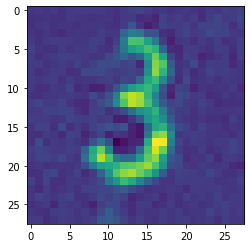

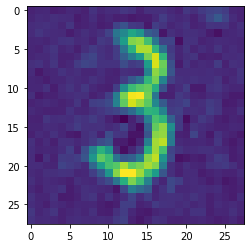

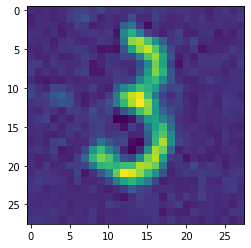

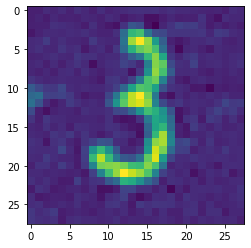

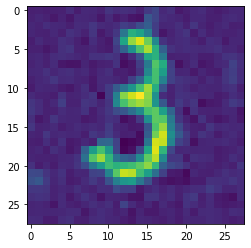

epoch: 2, step: 0, loss: 0.017331019043922424
epoch: 2, step: 200, loss: 0.01622280478477478


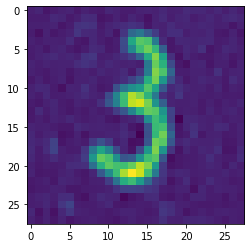

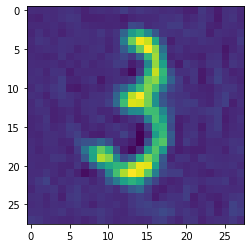

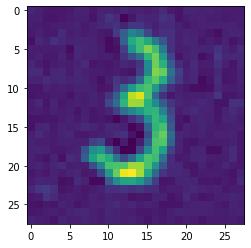

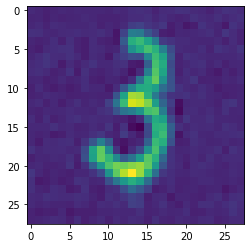

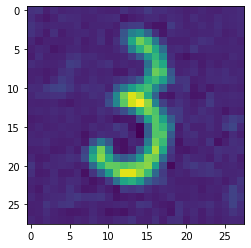

epoch: 3, step: 0, loss: 0.01602064073085785
epoch: 3, step: 200, loss: 0.015843909233808517


In [ ]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    data = batch['data'].to(device)
    # noized = torch.clamp(data + 
    #                      torch.normal(torch.zeros_like(data), 
    #                                   noise_factor * torch.ones_like(data)), 0., 1.)
    predict, mu, sigma = model_conv(data)
    loss = loss_func(predict, data) + 0.01 * kl_loss(mu, sigma)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  mu, sigma = model_conv.encoder(item.to(device))
  # item = torch.normal(torch.zeros((1,1,7,7)), 3 * torch.ones((1,1,7,7)))
  for i in range(5):
    plt.imshow(model_conv.decoder(sampling(mu, sigma))[0].squeeze().cpu().detach().numpy())
    plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')